# Insurance Data - Linear Models

In [1]:
%matplotlib inline

## Linear Regression

Imports...
Note that the models package contains several .py scripts to help with model analysis.

In [2]:
import numpy as np
import random as py_random
import numpy.random as np_random
import time
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
import models

sns.set(style="whitegrid")

Lets first download our insurance data set.

In [3]:
insurance = pd.read_csv("https://raw.githubusercontent.com/fundamentals-of-data-science/datasets/master/insurance.csv")

Now lets check that our import worked.

In [4]:
insurance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


It looks like our data import was successful. Lets now start building our model. Our target variable is the insurance charges on each account. We want to be able to predict insurance charges based on certain characterstics of the account holder. In that sense our y variable will be the charges variable and the other data points will be what influences our variable of interest. Because we've already done EDA in a previous lab, we can refer to the extract/transform/load and exploratory data analysis juptyer notebooks for more information on each individual variable.

In [5]:
insurance.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


Lets now think a little bit about how each variable might influence the charges variable so that we can build a model that would make sense given our domain knowledge:
* **age** - We know that the older a person is the higher the likliehood is that they require healthcare or are more likely to have conditions that require it. This should be a positive relationship.
* **sex** - This one is a little trickier. We know that females tend to have different healthcare requirements than males. From a population perspective, females live longer then males, and if age has a positive relationship with insurance charges, then female might see higher insurance charges. But because this is a categorical variable we'll have to do some modifications to the representations to properly incorporate this variable into our model.
* **bmi** - It seems like this would be a positive relationship, given our domain knowledge. Those who are overweight tend to have more health problems, resulting in higher insurance charges
* **children** - This one is hard to predict. I don't think we will find any relationship and if we do it might be easier to see if we converted it into a categorical variable as well.
* **smoker** - This was one of the most significant variables that affected insurance charges. I suspect this will have a strong positive relationship with insurance charges.
* **region** - This one is also very hard to predict. We would also need to do some variable transformations to make this one work in a model but the effects to me seem insignificant, at least from our EDA lab. I would honestly leave this variable out.

Lets now make the necessary modifications to our variables. For sex, we need to change it to a 0 - 1 variable, and lets add a categorical transformation of children to the data set. 

Sex categorical transformation: We will assign male patients the value of 1 and female subjects the value of 0. The baseline therefore is female subjects.

In [6]:
insurance["sex_mod"] = np.where(insurance["sex"] == 'male', 1, 0)
insurance.head()

,age,sex,bmi,children,smoker,region,charges,sex_mod
0,19,female,27.900,0,yes,southwest,16884.92400,0
1,18,male,33.770,1,no,southeast,1725.55230,1
2,28,male,33.000,3,no,southeast,4449.46200,1
3,33,male,22.705,0,no,northwest,21984.47061,1
4,32,male,28.880,0,no,northwest,3866.85520,1


Children categorical transformation: In a similar fashion, lets convert the children variable into a categorical variable.

In [7]:
insurance["hasChild"] = np.where(insurance["children"] > 0, 1, 0)
insurance.head()

,age,sex,bmi,children,smoker,region,charges,sex_mod,hasChild
0,19,female,27.900,0,yes,southwest,16884.92400,0,0
1,18,male,33.770,1,no,southeast,1725.55230,1,1
2,28,male,33.000,3,no,southeast,4449.46200,1,1
3,33,male,22.705,0,no,northwest,21984.47061,1,0
4,32,male,28.880,0,no,northwest,3866.85520,1,0


Smoker transformation: We simply need to convert yes to 1 and no to 0.

In [8]:
insurance["smoker"] = np.where(insurance["smoker"] == "yes", 1, 0)
insurance.head()

,age,sex,bmi,children,smoker,region,charges,sex_mod,hasChild
0,19,female,27.900,0,1,southwest,16884.92400,0,0
1,18,male,33.770,1,0,southeast,1725.55230,1,1
2,28,male,33.000,3,0,southeast,4449.46200,1,1
3,33,male,22.705,0,0,northwest,21984.47061,1,0
4,32,male,28.880,0,0,northwest,3866.85520,1,0


With these transformations, we can start building our linear model. Lets include all variables expect for the un-transformed variables sex and children, as well as region. This will give us a model that uses the following variables:

age, sex, bmi, has_child, and smoker.

In [9]:
model =  "charges ~ age + sex_mod + bmi + hasChild + smoker"
result = models.bootstrap_linear_regression(model, data=insurance)
models.describe_bootstrap_lr(result)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,-12101.34,-14010.63,-9624.64
age,$\beta_{1}$,257.83,236.95,278.87
sex_mod,$\beta_{2}$,-123.66,-692.48,443.98
bmi,$\beta_{3}$,322.22,253.24,378.17
hasChild,$\beta_{4}$,992.59,121.69,1726.41
smoker,$\beta_{5}$,23822.28,22918.27,24823.34
,,,,
Metrics</strong,Mean</strong,Lo</strong,Hi</strong,
$\sigma$,6076.79,5748.97,6354.91,


Right away the $R^2$ isn't too bad. about 75% of the variation can be explained by our model. To see if we did better than a null mean model, we can do a little description of the charges variable and see what the mean and standard deviation is.

In [10]:
insurance["charges"].describe()

count     1338.000000
mean     13270.422265
std      12110.011237
min       1121.873900
25%       4740.287150
50%       9382.033000
75%      16639.912515
max      63770.428010
Name: charges, dtype: float64

The error we get using our linear model is pretty good. Compared to the standard deviation of 12100 using the null model, we have an mean error of 6076. I'm fairly happy with this model, but lets explore a bit and see what each coefficient means.

In [11]:
predictions = {"age": "+", "sex_mod": "+", "bmi": "+", "hasChild": "+", "smoker": "+"}
models.evaluate_coefficient_predictions(predictions, result)

age P(>0)=1.000 (strong)
sex_mod P(>0)=0.350 (mixed)
bmi P(>0)=1.000 (strong)
hasChild P(>0)=0.980 (strong)
smoker P(>0)=1.000 (strong)


All variables that we obtained coefficients for seem to be positively related with charges, except for sex, which had a 95% BCI of -576 - 506. The rest of the variables actually offer very strong evidence of a positive relationship. According to our data set, there is a 100% chance that age, bmi, having children, and being a smoker all contribute in a positive manner to the amount o charges. This is informative, but we to what degree are each of these variables actually contributing to the differences in charges? One way we can start to tease apart these differences is by looking for any collinearity in our data set.

Using domain knowledge, we can start by perhaps looking at bmi and age. Surely as we age it becomes more difficult for people to maintain their weight and there might be a strong correlation between those two variables? The other ones don't make too much sense to investigate for collinearities. Would smoking and having children make any sense to investigate? I don't think so.

In [12]:
print("age v bmi = {0:.2f}".format(stats.pearsonr(insurance.age, insurance.bmi)[0]))

age v bmi = 0.11


It turns out that there isn't really that much correlation between those two variables so I suspect we're in the clear in that regard. Lets return to the sex variable and ask why that prediction is weak. In the EDA/ETL, we can return to the pairwise investigation of sex and charges that was performed. Lets repeat the boxplot comparison we did to illustrate.

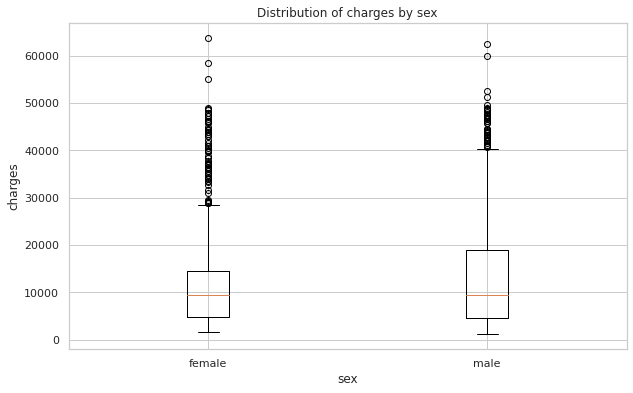

In [13]:
def multiboxplot(data, numeric, categorical, skip_data_points=True):
    figure = plt.figure(figsize=(10, 6))

    axes = figure.add_subplot(1, 1, 1)

    grouped = data.groupby(categorical)
    labels = pd.unique(data[categorical].values)
    labels.sort()
    grouped_data = [grouped[numeric].get_group( k) for k in labels]
    patch = axes.boxplot( grouped_data, labels=labels, zorder=1)

    if not skip_data_points:
        for i, k in enumerate(labels):
            subdata = grouped[numeric].get_group( k)
            x = np.random.normal(i + 1, 0.01, size=len(subdata))
            axes.plot(x, subdata, 'o', alpha=0.4, color="DimGray", zorder=2)

    axes.set_xlabel(categorical)
    axes.set_ylabel(numeric)
    axes.set_title("Distribution of {0} by {1}".format(numeric, categorical))

    plt.show()
    plt.close()

multiboxplot(insurance, 'charges', 'sex')

There isn't much of a difference between men and women so as expected it would be very hard to find a signal using sex as a variable.

Finally, we know we have a pretty good model with an $R^2$ of 0.75. Lets check the adjusted $R^2$ to see if that is a resulf of having 5 variables in our model.

In [14]:
models.adjusted_r_squared(result)

0.7478194540201135

Adjusting for the number of variables in our model, we still have a good $R^2$ of about 0.75. With this linear model, we correctly predicted the sign of each coefficient except for the has_children variable. As it turns out having children tends to increase the charge rate by a small amount. Nowhere near the amount associated with smoking, but this was interesting to see.

Now, we can go back and try and include region in our model. Its a categorical variable with 4 possibilities. In order to use this data point in our model we need to decide how to incorporate it into our model. First we need dummy variables. Luckily, pandas provides an easy way to do this.

In [15]:
insurance = pd.concat([insurance, pd.get_dummies(insurance["region"], prefix="in")], axis=1)
insurance.head()

,age,sex,bmi,children,smoker,region,charges,sex_mod,hasChild,in_northeast,in_northwest,in_southeast,in_southwest
0,19,female,27.900,0,1,southwest,16884.92400,0,0,0,0,0,1
1,18,male,33.770,1,0,southeast,1725.55230,1,1,0,0,1,0
2,28,male,33.000,3,0,southeast,4449.46200,1,1,0,0,1,0
3,33,male,22.705,0,0,northwest,21984.47061,1,0,0,1,0,0
4,32,male,28.880,0,0,northwest,3866.85520,1,0,0,1,0,0


We need $m-1$ variables for each of the $m$  one-hot encoded variables. As a baseline in our model, I will incoporate the northeast region because that is where I am from. (arbitrary I know but this data point seems arbitrary enough!) Perhaps different regions influence insurance charges due through differences in culture?

In [16]:
model =  "charges ~ age + sex_mod + bmi + hasChild + smoker + in_northwest + in_southwest + in_southeast"
result = models.bootstrap_linear_regression(model, data=insurance)
models.describe_bootstrap_lr(result)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,-12001.01,-14145.07,-9948.33
age,$\beta_{1}$,256.91,229.63,277.98
sex_mod,$\beta_{2}$,-126.41,-707.28,537.63
bmi,$\beta_{3}$,339.51,284.39,385.43
hasChild,$\beta_{4}$,999.58,466.24,1594.87
smoker,$\beta_{5}$,23849.65,22812.95,24977.94
in_northwest,$\beta_{6}$,-352.22,-1038.27,659.44
in_southwest,$\beta_{7}$,-944.26,-1839.31,-91.26
in_southeast,$\beta_{8}$,-1057.33,-1933.12,-280.41


First, incorporating region does virtually nothing for our $R^2$. We still have a respectable 75% of our variation explained by our model, and a decent 50% improvement in error compared to the standard null model (from about 12K to 6K). However, adjusting from the northeast region to other areas, we see and overall negative relationship with the southwest and southeast regions which was surprising to see. Lets look at our 95% BCIs and see if these are believable.

In [17]:
predictions = {"age": "+", "sex_mod": "+", "bmi": "+", "hasChild": "+", "smoker": "+", "in_northwest":"+", "in_southwest":"+", "in_southeast":"+"}
models.evaluate_coefficient_predictions(predictions, result)

age P(>0)=1.000 (strong)
sex_mod P(>0)=0.360 (mixed)
bmi P(>0)=1.000 (strong)
hasChild P(>0)=1.000 (strong)
smoker P(>0)=1.000 (strong)
in_northwest P(>0)=0.260 (weak)
in_southwest P(>0)=0.020 (weak)
in_southeast P(>0)=0.010 (weak)


All three regions have a pretty strong probability of being negatively correlated with the target variable. Both southwest and southeast are high at P<=0 of 0.99 and the northwest region with a P<=0 of 0.77. This was not what I expected before building this version of the model. Perhaps my misconception of those regions is due to me understanding the process that generates this insurance data set. Instead of thinking of the region as a predictor of lifestyle, perhaps its more of a predictor of pricing of medical care, where procedures are the same but cost is higher. This doesn't seem at all impossible given that cost of living in the northeast region like new york city or boston could be significantly higher than in more rural farm areas in the southeast (or anywhere in the midwest). Knowing how they geographically partitioned the USA into the four regions might help elucidate that difference a bit better as well. If there are more rural areas incorporated into regions that are not the northeast that could explain insurance costs being lower.

Overall, I'm rather satisfied with this linear model and would be comfortable doing some preliminary predictions using it.